#1. Upload Train Data to Train Model

In [1]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe

Saving train.csv to train.csv


# 2. Upload Test Data to Evaluate Model for its Accuracy 

In [2]:
uploaded2 = files.upload()
df_test = pd.read_csv(io.BytesIO(uploaded2['test.csv']))
# Dataset is now stored in a Pandas Dataframe

Saving test.csv to test.csv


In [3]:
df_train.head()


,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


In [4]:

df_test.head()

,text,emotion
0,feel incredibly weepy,0
1,feeling contented wife mother,1
2,pick novels feel like dropping luggage signing...,1
3,little extra interest right feeling like husba...,1
4,feel become even lot vital high eighty five we...,1


#3. Collect and Prepare the Data:

In [5]:
X_train,Y_train = df_train['text'],df_train['emotion']
X_test,Y_test = df_test['text'],df_test['emotion']

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
# with tf.device("/device:GPU:0"):
lem=WordNetLemmatizer()
sw_nltk =stopwords.words('english')

for i,sent in enumerate(X_train):
#print(i)
#sent=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sent)

  sent=sent.lower()
  sent=re.sub('https:\/\/\S+','',sent)
  sent=re.sub('@\S+','',sent)
  sent=re.sub('&[a-zA-Z]+;','',sent)
  sent=re.sub('#\S+','',sent)
  sent=re.sub('[^a-zA-Z0-9]',' ',sent)
  sent=sent.split()
  wds=''
  
  for word in sent:
    if word not in sw_nltk:
      word=lem.lemmatize(word)
      wds+=' '
      wds+=word
  X_train[i]=wds

<ipython-input-7-5e26513b3a25>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]=wds


# 4. Split the Data

In [8]:

from sklearn.model_selection import train_test_split
#90% to train , 10% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train,Y_train, test_size=0.1, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(
    num_words=254539,      
    oov_token="<OOV>"
)


tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(X_train)

padded_seq_train = pad_sequences(sequences_train, maxlen=75,padding='pre',dtype='float32')

sequences_val = tokenizer.texts_to_sequences(X_val)

padded_seq_val = pad_sequences(sequences_val, maxlen=75,padding='pre',dtype='float32')


sequences_eval = tokenizer.texts_to_sequences(X_test)

padded_seq_eval = pad_sequences(sequences_eval, maxlen=75,padding='pre',dtype='float32')



# 5. Train the Model

In [10]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
 
 
early_stopping = EarlyStopping(patience=3, monitor='val_loss')
	

reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,
	                        patience=5, mode='min',
	                        verbose=1)
	

model_checkpoint = ModelCheckpoint(monitor='val_loss', 
	                             filepath='./best_model.h5', 
	                             save_best_only=True)
	

callbacks = [
	    early_stopping,
	    reduce_lr,
	    model_checkpoint
	]
	


In [11]:
vocab_size = 229085
embedding_dim = 2
max_length = 75

import tensorflow.keras as tk
import tensorflow as tf
import numpy as np

my_model2 = tk.Sequential([
   tk.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
   tk.layers.Bidirectional(tk.layers.LSTM(32,return_sequences=True,kernel_initializer='he_normal')),
   tk.layers.Bidirectional(tk.layers.LSTM(32)),
   tk.layers.Dense(64, activation='relu'),
   tk.layers.Dropout(0.2),
   tk.layers.Dense(1, activation='relu')
])

padded_seq_train=np.array(padded_seq_train)
y_train=np.array(y_train)
padded_seq_test=np.array(padded_seq_val)
y_val=np.array(y_val)


my_model2.compile(optimizer='adam',
                loss = tf.keras.losses.binary_crossentropy,
                metrics=['accuracy'])

history1=my_model2.fit(padded_seq_train,
            y_train,   
             
            epochs=15,
            validation_data=(padded_seq_val, y_val),callbacks=[callbacks])

Epoch 1/15
7173/7173 [==============================] - 155s 20ms/step - loss: 0.2517 - accuracy: 0.9224 - val_loss: 0.1618 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 2/15
7173/7173 [==============================] - 119s 17ms/step - loss: 0.1547 - accuracy: 0.9599 - val_loss: 0.1662 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 3/15
7173/7173 [==============================] - 124s 17ms/step - loss: 0.1415 - accuracy: 0.9638 - val_loss: 0.1254 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 4/15
7173/7173 [==============================] - 119s 17ms/step - loss: 0.1135 - accuracy: 0.9728 - val_loss: 0.1358 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 5/15
7173/7173 [==============================] - 119s 17ms/step - loss: 0.0899 - accuracy: 0.9771 - val_loss: 0.1041 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 6/15
7173/7173 [==============================] - 118s 16ms/step - loss: 0.0760 - accuracy: 0.9815 - val_loss: 0.1495 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 7/15
7173/7173 [==================

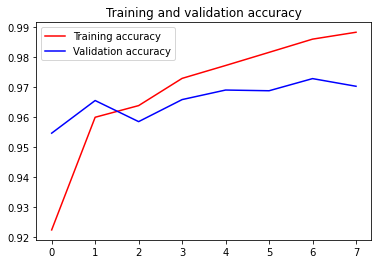

In [12]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy'] ### YOUR CODE HERE
val_acc = history1.history['val_accuracy'] ### YOUR CODE HERE
loss = history1.history['loss'] ### YOUR CODE HERE
val_loss = history1.history['val_loss'] ### YOUR CODE HERE

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.show()

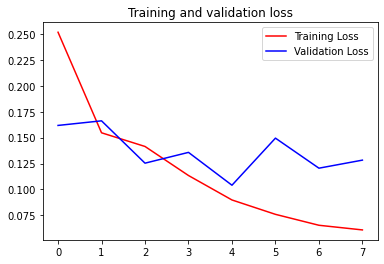

In [13]:

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
padded_seq_eval=np.array(padded_seq_eval)
Y_test=np.array(Y_test)

# Load best Model 

In [16]:
# Recreate the exact same model, including its weights and the optimizer
best_model = tf.keras.models.load_model('best_model.h5')

# Show the model architecture
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 2)             458170    
                                                                 
 bidirectional (Bidirectiona  (None, 75, 64)           8960      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

# Evaluate the Model

In [17]:
best_model.evaluate(padded_seq_eval,Y_test)

884/884 [==============================] - 8s 8ms/step - loss: 0.0980 - accuracy: 0.9667


[0.09797206521034241, 0.9666937589645386]

# predict the sentiment of new sentences.

In [18]:
x_prdict=['Losing a loved one is one of the saddest experiences anyone can go through',
          'Sometimes, no matter how hard we try, things just dont work out the way we want them to',
          'Its heart-wrenching to see someone you care about struggling and knowing theres nothing you can do to help them',
          'Sharing a good laugh with friends or family can be a great way to boost your mood and feel happy.',
          'Regret is a painful emotion that can haunt us for years and make us feel sad and hopeless ',
          'Doing something kind for someone else and seeing the positive impact it has on them can bring a sense of happiness and joy'];

sequences_predict = tokenizer.texts_to_sequences(x_prdict)

padded_seq_predict = pad_sequences(sequences_predict, maxlen=75,padding='pre',dtype='float32')

padded_seq_predict=np.array(padded_seq_predict)


In [19]:
result = best_model.predict(padded_seq_predict)
for i,j in enumerate(result):
  
  if j.round()==0:
    print(x_prdict[i] ,'\n Prediction is  : SAD\n')
  else:
    print(x_prdict[i] ,'\n Prediction is  : HAPPY\n')

1/1 [==============================] - 1s 1s/step
Losing a loved one is one of the saddest experiences anyone can go through 
 Prediction is  : SAD

Sometimes, no matter how hard we try, things just dont work out the way we want them to 
 Prediction is  : SAD

Its heart-wrenching to see someone you care about struggling and knowing theres nothing you can do to help them 
 Prediction is  : SAD

Sharing a good laugh with friends or family can be a great way to boost your mood and feel happy. 
 Prediction is  : HAPPY

Regret is a painful emotion that can haunt us for years and make us feel sad and hopeless  
 Prediction is  : SAD

Doing something kind for someone else and seeing the positive impact it has on them can bring a sense of happiness and joy 
 Prediction is  : HAPPY

